#Download do Dataset

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'eye-diseases-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2440665%2F4130910%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240706%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240706T000823Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dad26e7c150995e74f3f938548176d152f2bfc44273552b881c9124697dd6e89d4e5f259e188dfc21bf6ff925669a6c8a95fbace1de5f2fee02631a7cd15267b7c1051372cb741bdc85ecce3864ef69e3bc04286f08bda0b8a4e9456fb448c89bf43238d3c590cd0b05157969432efca232c9002e256637c55e2f35499700590e29332d00db88615aa2e0beaa2f66fdc1d95a3d1ddc220839487e8e94687be31b65940d313edacdb413507fbd06cdd7356acb6d83346ee7599a06752ed160583d2e15e9eeb5c5a8f09442ee019e57d68dbe864f3ccfc2914ba3aa561e68327a43331c02681e5df7fe23dc83364414e2eddbc2a897e352d734b2b49deb52254e80'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 771355331 bytes downloaded
Downloaded and uncompressed: eye-diseases-classification
Data source import complete.


# Instalação das bibliotecas

In [1]:
!pip install pandas numpy matplotlib seaborn tqdm opencv-python torch torchsummary torchmetrics

#Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
import cv2 as op
import torch
from torchsummary import summary
import torchmetrics

plt.style.use('seaborn')
np.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

<ipython-input-2-6530242ea47a>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


'cuda'

#Carregamento do Dataset

In [3]:
PATH = '/kaggle/input/eye-diseases-classification/dataset'
label2id = {}
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i

id2label = {key : value for (value, key) in label2id.items()}

filenames, outcome = [], []

for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label2id[label])


df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome
})

df = df.sample(frac = 1)
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,filename,outcome
3413,/kaggle/input/eye-diseases-classification/data...,3
3591,/kaggle/input/eye-diseases-classification/data...,3
2875,/kaggle/input/eye-diseases-classification/data...,2
2106,/kaggle/input/eye-diseases-classification/data...,2
3752,/kaggle/input/eye-diseases-classification/data...,3


## Gráfico de distribuição de dados

In [2]:
sea.countplot(x = 'outcome', data = df, palette = 'Set2')

NameError: name 'sea' is not defined

## Print de algumas imagens




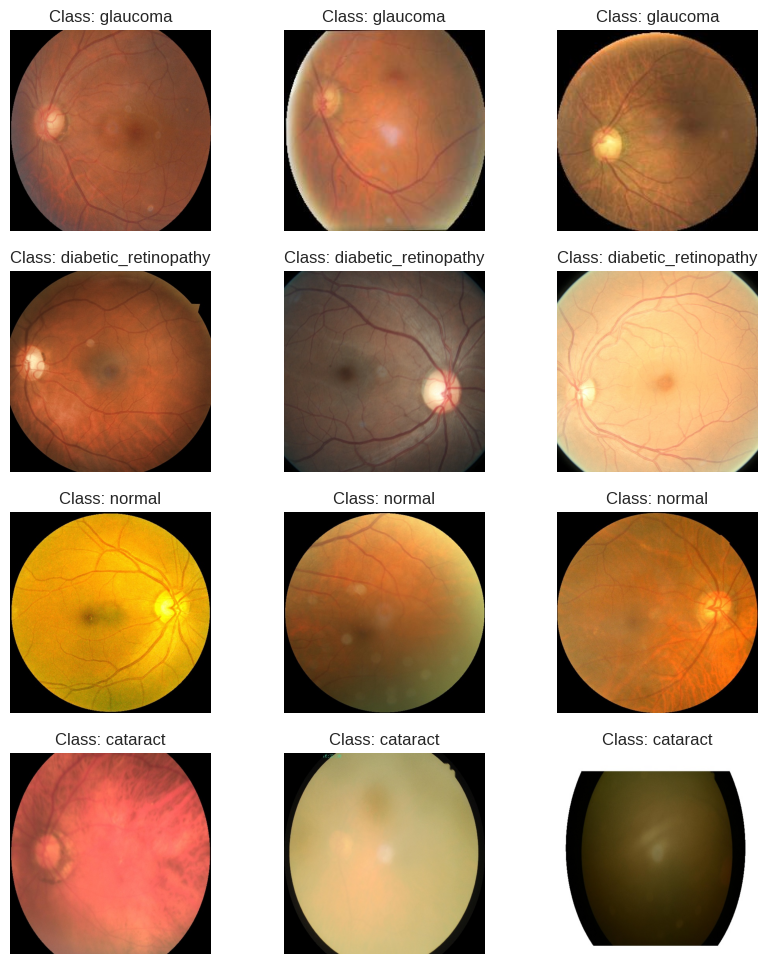

In [5]:
def load_image(path):
    img = plt.imread(path)
    img = (img - img.min())/img.max()
    return img

counter = 0

plt.figure(figsize = (10, 12))

for i in range(4):
    for path in df[df['outcome'] == i].sample(n = 3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + id2label[i])
        counter += 1

plt.show()

# Pré-processamento

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as f

### Augmentation

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.RandomAutocontrast(p = 0.5),
    transforms.RandomRotation(degrees = 15)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = (224, 224))
])

###Dataloader

class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform = None):
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        img = plt.imread(self.df.iloc[index, 0])
        label = self.df.iloc[index, 1]

        img = (img - img.min())/img.max()

        if self.transform:
            img = self.transform(img)

        return img.to(torch.float32), label

###Distribuição do dataset

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size = 0.15, random_state = 28)

df_train.shape, df_val.shape


((3584, 2), (633, 2))

### Definição de parametros

In [ ]:
NUM_CLASSES = 4
BATCH_SIZE = 128

###Carregamento do Dataloader

In [8]:

train_dataset = EyeDataset(df_train, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(df_val, NUM_CLASSES, val_transform)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [9]:
a, b = next(iter(train_loader))

print(a.shape, b.shape)
del(a)
del(b)

torch.Size([128, 3, 224, 224]) torch.Size([128])


# Modelo

In [11]:
from math import ceil

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.resnet18(pretrained = True) ### Definição do modelo

        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False

        self.block = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
        )
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()


    def get_optimizer(self):
        return torch.optim.AdamW([
            {'params' : self.base.parameters(), 'lr': 3e-5},
            {'params' : self.block.parameters(), 'lr': 8e-4}
        ])


    def forward(self, x):
        x = self.base(x)
        x = self.block(x)
        return x


class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader= val_loader
        self.device = device

        self.model = Net().to(self.device)
        self.optimizer = self.model.get_optimizer()
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes = NUM_CLASSES).to(self.device)

        self.history = {'train_loss' : [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def step_fxn(self, loader, step):
        loss, acc = 0, 0

        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()

        return loss/len(loader), acc/len(loader)

    def train(self, epochs):

        for epoch in tqdm(range(epochs)):

            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)

            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)


            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))


In [12]:
trainer = Trainer(train_loader, val_loader, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


## Resumo do modelo

In [13]:
summary(trainer.model.base, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

#Treinamento

In [14]:
trainer.train(epochs = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.786 acc: 0.679] Val: [loss: 0.522 acc:0.793]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.481 acc: 0.819] Val: [loss: 0.397 acc:0.850]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 3] Train: [loss: 0.355 acc: 0.873] Val: [loss: 0.323 acc:0.877]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 4] Train: [loss: 0.315 acc: 0.881] Val: [loss: 0.280 acc:0.897]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 5] Train: [loss: 0.265 acc: 0.902] Val: [loss: 0.279 acc:0.899]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 6] Train: [loss: 0.237 acc: 0.911] Val: [loss: 0.262 acc:0.900]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 7] Train: [loss: 0.228 acc: 0.912] Val: [loss: 0.245 acc:0.909]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 8] Train: [loss: 0.223 acc: 0.915] Val: [loss: 0.254 acc:0.905]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 9] Train: [loss: 0.194 acc: 0.926] Val: [loss: 0.234 acc:0.907]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 10] Train: [loss: 0.179 acc: 0.927] Val: [loss: 0.238 acc:0.907]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 11] Train: [loss: 0.170 acc: 0.934] Val: [loss: 0.224 acc:0.916]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 12] Train: [loss: 0.158 acc: 0.941] Val: [loss: 0.256 acc:0.905]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 13] Train: [loss: 0.160 acc: 0.935] Val: [loss: 0.233 acc:0.921]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 14] Train: [loss: 0.159 acc: 0.935] Val: [loss: 0.209 acc:0.916]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 15] Train: [loss: 0.147 acc: 0.939] Val: [loss: 0.241 acc:0.913]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 16] Train: [loss: 0.149 acc: 0.942] Val: [loss: 0.211 acc:0.925]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 17] Train: [loss: 0.121 acc: 0.953] Val: [loss: 0.230 acc:0.919]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 18] Train: [loss: 0.124 acc: 0.949] Val: [loss: 0.222 acc:0.914]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 19] Train: [loss: 0.112 acc: 0.958] Val: [loss: 0.222 acc:0.916]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 20] Train: [loss: 0.115 acc: 0.955] Val: [loss: 0.229 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 21] Train: [loss: 0.124 acc: 0.956] Val: [loss: 0.255 acc:0.918]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 22] Train: [loss: 0.103 acc: 0.962] Val: [loss: 0.241 acc:0.919]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 23] Train: [loss: 0.093 acc: 0.964] Val: [loss: 0.248 acc:0.916]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 24] Train: [loss: 0.090 acc: 0.965] Val: [loss: 0.297 acc:0.910]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 25] Train: [loss: 0.093 acc: 0.962] Val: [loss: 0.248 acc:0.921]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 26] Train: [loss: 0.087 acc: 0.966] Val: [loss: 0.237 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 27] Train: [loss: 0.074 acc: 0.971] Val: [loss: 0.230 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 28] Train: [loss: 0.087 acc: 0.966] Val: [loss: 0.260 acc:0.915]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 29] Train: [loss: 0.059 acc: 0.979] Val: [loss: 0.234 acc:0.923]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 30] Train: [loss: 0.072 acc: 0.969] Val: [loss: 0.272 acc:0.916]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 31] Train: [loss: 0.062 acc: 0.975] Val: [loss: 0.264 acc:0.923]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 32] Train: [loss: 0.064 acc: 0.974] Val: [loss: 0.257 acc:0.921]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 33] Train: [loss: 0.076 acc: 0.971] Val: [loss: 0.241 acc:0.927]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 34] Train: [loss: 0.054 acc: 0.980] Val: [loss: 0.257 acc:0.919]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 35] Train: [loss: 0.058 acc: 0.982] Val: [loss: 0.263 acc:0.918]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 36] Train: [loss: 0.051 acc: 0.980] Val: [loss: 0.252 acc:0.921]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 37] Train: [loss: 0.055 acc: 0.980] Val: [loss: 0.234 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 38] Train: [loss: 0.045 acc: 0.984] Val: [loss: 0.244 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 39] Train: [loss: 0.055 acc: 0.980] Val: [loss: 0.248 acc:0.918]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 40] Train: [loss: 0.045 acc: 0.984] Val: [loss: 0.259 acc:0.924]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 41] Train: [loss: 0.042 acc: 0.984] Val: [loss: 0.239 acc:0.930]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 42] Train: [loss: 0.052 acc: 0.981] Val: [loss: 0.247 acc:0.924]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 43] Train: [loss: 0.040 acc: 0.986] Val: [loss: 0.280 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 44] Train: [loss: 0.043 acc: 0.983] Val: [loss: 0.263 acc:0.924]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 45] Train: [loss: 0.042 acc: 0.982] Val: [loss: 0.246 acc:0.937]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 46] Train: [loss: 0.042 acc: 0.983] Val: [loss: 0.238 acc:0.924]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 47] Train: [loss: 0.031 acc: 0.989] Val: [loss: 0.263 acc:0.937]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 48] Train: [loss: 0.037 acc: 0.987] Val: [loss: 0.247 acc:0.933]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 49] Train: [loss: 0.027 acc: 0.990] Val: [loss: 0.292 acc:0.929]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 50] Train: [loss: 0.038 acc: 0.985] Val: [loss: 0.312 acc:0.919]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 51] Train: [loss: 0.041 acc: 0.984] Val: [loss: 0.241 acc:0.937]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 52] Train: [loss: 0.034 acc: 0.989] Val: [loss: 0.264 acc:0.929]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 53] Train: [loss: 0.026 acc: 0.991] Val: [loss: 0.269 acc:0.932]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 54] Train: [loss: 0.026 acc: 0.991] Val: [loss: 0.258 acc:0.932]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 55] Train: [loss: 0.034 acc: 0.986] Val: [loss: 0.284 acc:0.924]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 56] Train: [loss: 0.026 acc: 0.991] Val: [loss: 0.283 acc:0.926]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 57] Train: [loss: 0.025 acc: 0.992] Val: [loss: 0.258 acc:0.927]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 58] Train: [loss: 0.027 acc: 0.991] Val: [loss: 0.302 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 59] Train: [loss: 0.028 acc: 0.993] Val: [loss: 0.326 acc:0.926]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 60] Train: [loss: 0.023 acc: 0.992] Val: [loss: 0.275 acc:0.933]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 61] Train: [loss: 0.025 acc: 0.990] Val: [loss: 0.268 acc:0.929]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 62] Train: [loss: 0.020 acc: 0.994] Val: [loss: 0.272 acc:0.921]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 63] Train: [loss: 0.025 acc: 0.992] Val: [loss: 0.291 acc:0.918]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 64] Train: [loss: 0.023 acc: 0.991] Val: [loss: 0.274 acc:0.929]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 65] Train: [loss: 0.022 acc: 0.994] Val: [loss: 0.307 acc:0.922]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 66] Train: [loss: 0.025 acc: 0.990] Val: [loss: 0.265 acc:0.935]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 67] Train: [loss: 0.019 acc: 0.993] Val: [loss: 0.255 acc:0.930]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 68] Train: [loss: 0.023 acc: 0.992] Val: [loss: 0.295 acc:0.937]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 69] Train: [loss: 0.019 acc: 0.992] Val: [loss: 0.296 acc:0.930]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 70] Train: [loss: 0.020 acc: 0.994] Val: [loss: 0.273 acc:0.934]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 71] Train: [loss: 0.019 acc: 0.992] Val: [loss: 0.309 acc:0.929]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 72] Train: [loss: 0.020 acc: 0.991] Val: [loss: 0.323 acc:0.929]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 73] Train: [loss: 0.019 acc: 0.992] Val: [loss: 0.351 acc:0.924]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 74] Train: [loss: 0.024 acc: 0.989] Val: [loss: 0.295 acc:0.935]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 75] Train: [loss: 0.022 acc: 0.992] Val: [loss: 0.296 acc:0.934]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 76] Train: [loss: 0.025 acc: 0.990] Val: [loss: 0.368 acc:0.921]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 77] Train: [loss: 0.026 acc: 0.991] Val: [loss: 0.299 acc:0.932]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 78] Train: [loss: 0.017 acc: 0.993] Val: [loss: 0.316 acc:0.923]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 79] Train: [loss: 0.034 acc: 0.988] Val: [loss: 0.354 acc:0.915]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 80] Train: [loss: 0.018 acc: 0.993] Val: [loss: 0.291 acc:0.934]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 81] Train: [loss: 0.018 acc: 0.993] Val: [loss: 0.317 acc:0.932]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 82] Train: [loss: 0.017 acc: 0.994] Val: [loss: 0.301 acc:0.942]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 83] Train: [loss: 0.011 acc: 0.996] Val: [loss: 0.328 acc:0.940]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 84] Train: [loss: 0.015 acc: 0.995] Val: [loss: 0.294 acc:0.935]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 85] Train: [loss: 0.015 acc: 0.994] Val: [loss: 0.299 acc:0.940]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 86] Train: [loss: 0.020 acc: 0.992] Val: [loss: 0.262 acc:0.943]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 87] Train: [loss: 0.016 acc: 0.994] Val: [loss: 0.288 acc:0.939]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 88] Train: [loss: 0.020 acc: 0.994] Val: [loss: 0.303 acc:0.931]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 89] Train: [loss: 0.018 acc: 0.994] Val: [loss: 0.305 acc:0.935]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 90] Train: [loss: 0.015 acc: 0.994] Val: [loss: 0.368 acc:0.935]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 91] Train: [loss: 0.015 acc: 0.995] Val: [loss: 0.360 acc:0.927]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 92] Train: [loss: 0.016 acc: 0.996] Val: [loss: 0.383 acc:0.934]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 93] Train: [loss: 0.016 acc: 0.994] Val: [loss: 0.357 acc:0.929]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 94] Train: [loss: 0.022 acc: 0.992] Val: [loss: 0.292 acc:0.937]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 95] Train: [loss: 0.016 acc: 0.993] Val: [loss: 0.299 acc:0.943]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 96] Train: [loss: 0.012 acc: 0.996] Val: [loss: 0.306 acc:0.940]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 97] Train: [loss: 0.008 acc: 0.997] Val: [loss: 0.311 acc:0.934]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 98] Train: [loss: 0.014 acc: 0.994] Val: [loss: 0.327 acc:0.937]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 99] Train: [loss: 0.015 acc: 0.994] Val: [loss: 0.327 acc:0.934]


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 100] Train: [loss: 0.015 acc: 0.996] Val: [loss: 0.309 acc:0.930]


# Resultado do Treinamento
## Loss e Acurácia



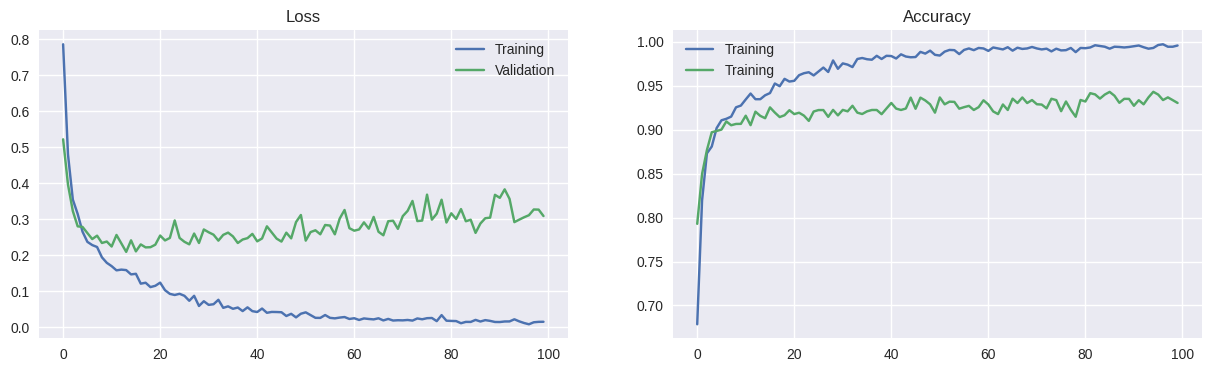

In [15]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Training')
plt.legend()



#Predição do dataset de Validação

In [16]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)

len(preds), len(true)

  0%|          | 0/5 [00:00<?, ?it/s]

(633, 633)

#Matriz de Confusão

Text(0.5, 1.0, 'Confusion Matrix')

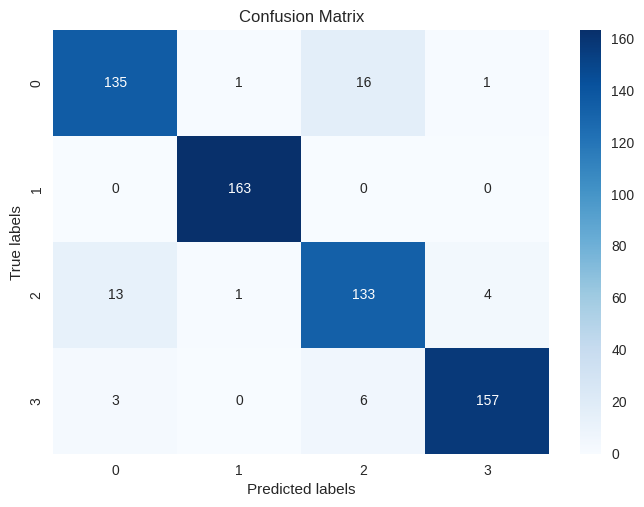

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [18]:
from sklearn.metrics import classification_report

print(classification_report(true, preds, target_names = label2id.keys()))

                      precision    recall  f1-score   support

            glaucoma       0.89      0.88      0.89       153
diabetic_retinopathy       0.99      1.00      0.99       163
              normal       0.86      0.88      0.87       151
            cataract       0.97      0.95      0.96       166

            accuracy                           0.93       633
           macro avg       0.93      0.93      0.93       633
        weighted avg       0.93      0.93      0.93       633

